In [1]:
# Imports
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import access_api as api
from datetime import datetime, timedelta

2021-11-28 18:54:11.475472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-28 18:54:11.475493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
ticker = "AAPL"
start_date = datetime(year = 2019, month = 11, day = 10)
end_date = datetime(year = 2021, month = 11, day = 10)
df = api.get_stock_data(ticker, start_date, end_date)
print(df.head()) #7 columns, including the Date. 

                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2019-11-11  65.617500  64.570000  64.574997  65.550003   81821200.0  64.590576
2019-11-12  65.697502  65.230003  65.387497  65.489998   87388800.0  64.531456
2019-11-13  66.195000  65.267502  65.282501  66.117500  102734400.0  65.149757
2019-11-14  66.220001  65.525002  65.937500  65.660004   89182800.0  64.698959
2019-11-15  66.445000  65.752502  65.919998  66.440002  100206400.0  65.467545


In [3]:
df = df.dropna()
df["Date"] = df.index
df.index = range(1, df.shape[0] + 1)
df

,High,Low,Open,Close,Volume,Adj Close,Date
1,65.617500,64.570000,64.574997,65.550003,81821200.0,64.590576,2019-11-11
2,65.697502,65.230003,65.387497,65.489998,87388800.0,64.531456,2019-11-12
3,66.195000,65.267502,65.282501,66.117500,102734400.0,65.149757,2019-11-13
4,66.220001,65.525002,65.937500,65.660004,89182800.0,64.698959,2019-11-14
5,66.445000,65.752502,65.919998,66.440002,100206400.0,65.467545,2019-11-15
...,...,...,...,...,...,...,...
501,152.429993,150.639999,151.580002,150.960007,60394600.0,150.740005,2021-11-04
502,152.199997,150.059998,151.889999,151.279999,65414600.0,151.279999,2021-11-05
503,151.570007,150.160004,151.410004,150.440002,55020900.0,150.440002,2021-11-08
504,151.429993,150.059998,150.199997,150.809998,56787900.0,150.809998,2021-11-09


In [4]:
target_var = "Adj Close"

In [5]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
# print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)
cols.remove("Date")
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


In [6]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [7]:
target_var_x_index = list(df_for_training).index(target_var)
target_var_x_index

5

In [8]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 60  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    # trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    # trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    # Predict Adj Close instead of Open
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, target_var_x_index])


trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

trainX shape == (445, 60, 6).
trainY shape == (445, 1).


In [9]:
# define the Autoencoder model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

2021-11-28 18:54:14.859398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-28 18:54:14.859414: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-28 18:54:14.859426: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-ThinkPad-T490): /proc/driver/nvidia/version does not exist
2021-11-28 18:54:14.859621: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [10]:
# fit the model
history = model.fit(trainX, trainY, epochs=25, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/25


2021-11-28 18:54:15.153570: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


25/25 [==============================] - 2s 39ms/step - loss: 0.2153 - val_loss: 0.0344
Epoch 2/25
25/25 [==============================] - 1s 28ms/step - loss: 0.0538 - val_loss: 0.0164
Epoch 3/25
25/25 [==============================] - 1s 26ms/step - loss: 0.0502 - val_loss: 0.0128
Epoch 4/25
25/25 [==============================] - 1s 26ms/step - loss: 0.0411 - val_loss: 0.0194
Epoch 5/25
25/25 [==============================] - 1s 28ms/step - loss: 0.0401 - val_loss: 0.0297
Epoch 6/25
25/25 [==============================] - 1s 28ms/step - loss: 0.0454 - val_loss: 0.0099
Epoch 7/25
25/25 [==============================] - 1s 34ms/step - loss: 0.0443 - val_loss: 0.0454
Epoch 8/25
25/25 [==============================] - 1s 48ms/step - loss: 0.0391 - val_loss: 0.0100
Epoch 9/25
25/25 [==============================] - 1s 46ms/step - loss: 0.0402 - val_loss: 0.0141
Epoch 10/25
25/25 [==============================] - 1s 50ms/step - loss: 0.0369 - val_loss: 0.0144
Epoch 11/25
25/25 [=

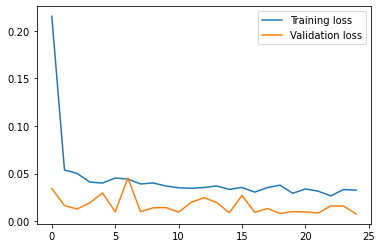

In [11]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [12]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [13]:
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 1
n_days_for_prediction=21  #let us predict past 15 days

In [14]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
# print(predict_period_dates)

In [15]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
# prediction

In [16]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,target_var_x_index]

In [17]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Adj Close':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [18]:
original = df[['Date', 'Adj Close']].copy()
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-5-1']

In [19]:
# sns.lineplot(x = original['Date'], y = original['Adj Close'])
# sns.lineplot(x = df_forecast['Date'], y = df_forecast['Adj Close'])

In [20]:
# Store the data in one dataset so that we can plot a continuous line
combined_dfs = original.append(df_forecast)
last_date_from_data = original["Date"][original.index[-1]]

In [21]:
# import matplotlib.dates as mdates
# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%Y-%m') #This is a format. Will be clear in Screenshot

# axes.xaxis.set_major_locator(months)
# axes.xaxis.set_major_formatter(years_fmt)
# axes.xaxis.set_minor_locator(months)

<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

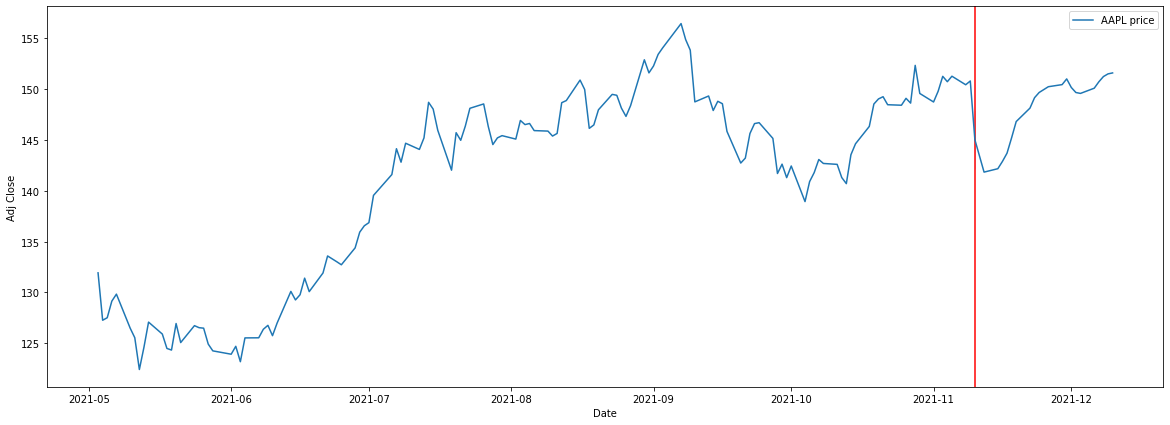

In [22]:
fig, axes = plt.subplots(figsize=(20,7))
plt.axvline(last_date_from_data, color = "r")
sns.lineplot(x = combined_dfs["Date"], y = combined_dfs[target_var], label = 'AAPL price')

# Old code

In [23]:


# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dense, Dropout
# import pandas as pd
# from matplotlib import pyplot as plt
# from sklearn.preprocessing import StandardScaler
# import seaborn as sns
# #from datetime import datetime

# #Read the csv file
# df = pd.read_csv('AAPL.csv')
# print(df.head()) #7 columns, including the Date. 

# #Separate dates for future plotting
# train_dates = pd.to_datetime(df['Date'])
# print(train_dates.tail(15)) #Check last few dates. 

# #Variables for training
# cols = list(df)[1:6]
# #Date and volume columns are not used in training. 
# print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

# #New dataframe with only training data - 5 columns
# df_for_training = df[cols].astype(float)

# # df_for_plot=df_for_training.tail(5000)
# # df_for_plot.plot.line()

# #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# # normalize the dataset
# scaler = StandardScaler()
# scaler = scaler.fit(df_for_training)
# df_for_training_scaled = scaler.transform(df_for_training)


# #As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# #In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# #Empty lists to be populated using formatted training data
# trainX = []
# trainY = []

# n_future = 1   # Number of days we want to look into the future based on the past days.
# n_past = 60  # Number of past days we want to use to predict the future.

# #Reformat input data into a shape: (n_samples x timesteps x n_features)
# #In my example, my df_for_training_scaled has a shape (12823, 5)
# #12823 refers to the number of data points and 5 refers to the columns (multi-variables).
# for i in range(n_past, len(df_for_training_scaled) - n_future +1):
#     trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
#     trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# trainX, trainY = np.array(trainX), np.array(trainY)

# print('trainX shape == {}.'.format(trainX.shape))
# print('trainY shape == {}.'.format(trainY.shape))

# #In my case, trainX has a shape (12809, 14, 5). 
# #12809 because we are looking back 14 days (12823 - 14 = 12809). 
# #Remember that we cannot look back 14 days until we get to the 15th day. 
# #Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
# #it needs multiple variables (5 in my example) to make this prediction. 
# #This is why we can only predict a single day after our training, the day after where our data ends.
# #To predict more days in future, we need all the 5 variables which we do not have. 
# #We need to predict all variables if we want to do that. 

# # define the Autoencoder model

# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1]))

# model.compile(optimizer='adam', loss='mse')
# model.summary()


# # fit the model
# history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()

# #Predicting...
# #Libraries that will help us extract only business days in the US.
# #Otherwise our dates would be wrong when we look back (or forward).  
# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay
# us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
# #Remember that we can only predict one day in future as our model needs 5 variables
# #as inputs for prediction. We only have all 5 variables until the last day in our dataset.
# n_past = 16
# n_days_for_prediction=15  #let us predict past 15 days

# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
# print(predict_period_dates)

# #Make prediction
# prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

# #Perform inverse transformation to rescale back to original range
# #Since we used 5 variables for transform, the inverse expects same dimensions
# #Therefore, let us copy our values 5 times and discard them after inverse transform
# prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
# y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# # Convert timestamp to date
# forecast_dates = []
# for time_i in predict_period_dates:
#     forecast_dates.append(time_i.date())
    
# df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
# df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


# original = df[['Date', 'Open']]
# original['Date']=pd.to_datetime(original['Date'])
# original = original.loc[original['Date'] >= '2019-11-11']

# sns.lineplot(original['Date'], original['Open'])
# sns.lineplot(df_forecast['Date'], df_forecast['Open'])